In [1]:
#%pip install -U --no-cache-dir "pandas==2.2.2" "pyarrow==15.0.2" "datasets==2.20.0" transformers accelerate evaluate
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.7 MB/s eta 0:00:00


In [2]:
import pandas as pd, pyarrow, datasets
print("pandas:", pd.__version__)
print("pyarrow:", pyarrow.__version__)
print("datasets:", datasets.__version__)

pandas: 2.2.2
pyarrow: 18.1.0
datasets: 4.0.0


In [3]:
#Import resources

#!pip install nltk scikit-learn pandas matplotlib
#%pip install seaborn

#0%pip uninstall -y pyarrow datasets
#%pip install -U --no-cache-dir --force-reinstall "pyarrow==15.0.2" "datasets==2.20.0"


import nltk
import re
import string
#import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns


In [4]:
#Import libraries

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
#Load the file
df = pd.read_csv("/content/training_data_lowercase.csv")

Data analyse


In [6]:
#Read the data
df = pd.read_csv('/content/training_data_lowercase.csv', sep='\t', header=None, names=['label', 'title'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   34152 non-null  int64 
 1   title   34152 non-null  object
dtypes: int64(1), object(1)
memory usage: 533.8+ KB


In [7]:
#Data analyse
df.head()

,label,title
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


In [8]:
#Remove "\t" and label first number and the headline
df = pd.read_csv('/content/training_data_lowercase.csv', sep='\t', header=None, names=['label', 'title'])
df.head()

,label,title
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


In [9]:
# Basic info
print("=== DATA TYPES ===")
print(df.dtypes)
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

=== DATA TYPES ===
label     int64
title    object
dtype: object

=== MISSING VALUES ===
label    0
title    0
dtype: int64


In [10]:
# Class distribution
print("=== CLASS DISTRIBUTION ===")
print(df['label'].value_counts())
print(f"\nPercentage:")
print(df['label'].value_counts(normalize=True) * 100)

=== CLASS DISTRIBUTION ===
label
0    17572
1    16580
Name: count, dtype: int64

Percentage:
label
0    51.452331
1    48.547669
Name: proportion, dtype: float64


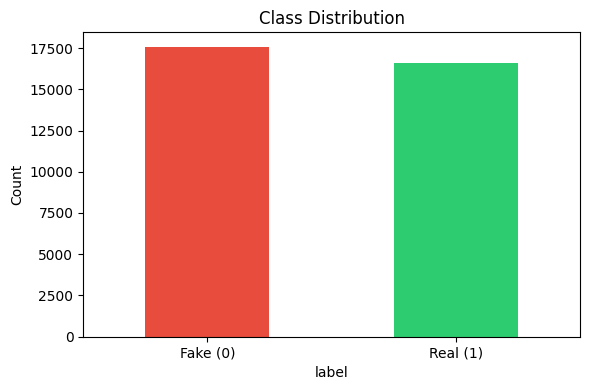

In [11]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(6, 4))
df['label'].value_counts().plot(kind='bar', color=['#e74c3c', '#2ecc71'], ax=ax)
ax.set_xticklabels(['Fake (0)', 'Real (1)'], rotation=0)
ax.set_ylabel('Count')
ax.set_title('Class Distribution')
plt.tight_layout()
plt.show()

In [12]:
# Add text length features for analysis
df['char_count'] = df['title'].str.len()
df['word_count'] = df['title'].str.split().str.len()

print("=== TITLE LENGTH BY CLASS (WORDS) ===")
print(df.groupby('label')['word_count'].describe())


=== TITLE LENGTH BY CLASS (WORDS) ===
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      17572.0  13.364671  4.495321  1.0  11.0  13.0  16.0  42.0
1      16580.0   9.916647  1.693058  4.0   9.0  10.0  11.0  20.0


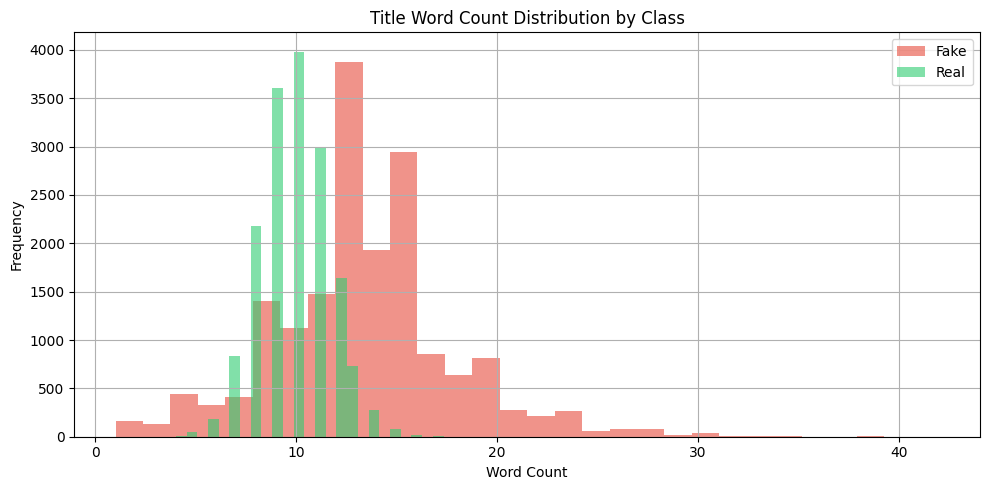

In [13]:
# Visualize word count distribution by class
fig, ax = plt.subplots(figsize=(10, 5))
df[df['label']==0]['word_count'].hist(alpha=0.6, label='Fake', bins=30, color='#e74c3c', ax=ax)
df[df['label']==1]['word_count'].hist(alpha=0.6, label='Real', bins=30, color='#2ecc71', ax=ax)
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.set_title('Title Word Count Distribution by Class')
ax.legend()
plt.tight_layout()
plt.show()

In [14]:
# Check for tabs in titles
df['has_tab'] = df['title'].str.contains('\t')
print("=== TITLES WITH TABS ===")
print(f"Total: {df['has_tab'].sum()}")
print(f"\nBy class:")
print(df.groupby('label')['has_tab'].sum())

=== TITLES WITH TABS ===
Total: 3536

By class:
label
0       0
1    3536
Name: has_tab, dtype: int64


In [15]:
# Check for URLs in titles
df['has_url'] = df['title'].str.contains('http')
print("=== TITLES WITH URLs ===")
print(f"Total: {df['has_url'].sum()}")
print(f"\nBy class:")
print(df.groupby('label')['has_url'].sum())

=== TITLES WITH URLs ===
Total: 7

By class:
label
0    7
1    0
Name: has_url, dtype: int64


In [16]:
# Check for very short titles
short_titles = df[df['word_count'] <= 3]
print(f"=== VERY SHORT TITLES (≤3 words) ===")
print(f"Total: {len(short_titles)}")
print(f"\nBy class:")
print(short_titles['label'].value_counts())

=== VERY SHORT TITLES (≤3 words) ===
Total: 292

By class:
label
0    292
Name: count, dtype: int64


In [17]:
# Check for very long titles
long_titles = df[df['word_count'] >= 17]
print(f"=== VERY LONG TITLES (>=17 words) ===")
print(f"Total: {len(long_titles)}")
print(f"\nBy class:")
print(long_titles['label'].value_counts())

=== VERY LONG TITLES (>=17 words) ===
Total: 3366

By class:
label
0    3362
1       4
Name: count, dtype: int64


In [18]:
# Sample titles by class
print("=== SAMPLE FAKE NEWS TITLES ===")
for title in df[df['label']==0]['title'].head(5):
    print(f"- {title}")

print("\n=== SAMPLE REAL NEWS TITLES ===")
for title in df[df['label']==1]['title'].head(5):
    print(f"- {title}")

=== SAMPLE FAKE NEWS TITLES ===
- donald trump sends out embarrassing new year‚s eve message; this is disturbing
- drunk bragging trump staffer started russian collusion investigation
- sheriff david clarke becomes an internet joke for threatening to poke people ‚in the eye‚
- trump is so obsessed he even has obama‚s name coded into his website (images)
- pope francis just called out donald trump during his christmas speech

=== SAMPLE REAL NEWS TITLES ===
- as u.s. budget fight looms	republicans flip their fiscal script
- u.s. military to accept transgender recruits on monday: pentagon
- senior u.s. republican senator: 'let mr. mueller do his job'
- fbi russia probe helped by australian diplomat tip-off: nyt
- trump wants postal service to charge 'much more' for amazon shipments


### EDA Summary

**Key Findings:**
- Dataset: 34,152 rows, well-balanced classes (~51% fake, ~49% real)
- Fake news titles are longer (avg 13 words) vs real (avg 10 words)
- Tab characters appear ONLY in real news (3,536 titles) - strong signal
- URLs appear ONLY in fake news titles
- Very short titles (≤2 words) are all fake news

**Potential Features:**
1. `word_count` - title length
2. `has_tab` - presence of tab character
3. `has_url` - presence of URL
4. Text vectorization (TF-IDF)

In [19]:
#Check for duplicate
df.duplicated().sum()
#identify duplicates
df[df.duplicated(keep=False)]

,label,title,char_count,word_count,has_tab,has_url
678,0,thanks to trump,15,3,False,False
986,0,no,2,1,False,False
1487,0,mcconnell says he‚ll obstruct any effort to hi...,79,11,False,False
1534,0,mcconnell says he‚ll obstruct any effort to hi...,79,11,False,False
1619,0,trump freaks out,16,3,False,False
...,...,...,...,...,...,...
34049,1,u.s. house passes sanctions on iran-backed hez...,52,7,False,False
34053,1,thailand kicks off sumptuous funeral of king b...,63,9,False,False
34054,1,trump declines to say if he will visit korean ...,62,13,False,False
34126,1,thailand kicks off sumptuous funeral of king b...,63,9,False,False


In [20]:

# Replace tabs with spaces
df = df.replace('\t', ' ')

# Fix common encoding issues with apostrophes
df = df.replace('‚', "'")
df = df.replace(''', "'")
df = df.replace(''', "'")

# Remove extra whitespace
#df = ' '.join(df.split())
stop_words = set(stopwords.words('english'))
pattern = re.compile('[%s]' % re.escape(string.punctuation))


SBERT + Logistic Regression

Create TF-IDF

Install dependencies

In [21]:
#%pip -q install -U transformers datasets accelerate evaluate pyarrow

Load data

In [22]:
df = df.dropna(subset=["title", "label"]).copy()
df["title"] = df["title"].astype(str)
df["label"] = df["label"].astype(int)  # ensure 0/1
df.head()

,label,title,char_count,word_count,has_tab,has_url
0,0,donald trump sends out embarrassing new year‚s...,78,12,False,False
1,0,drunk bragging trump staffer started russian c...,68,8,False,False
2,0,sheriff david clarke becomes an internet joke ...,89,15,False,False
3,0,trump is so obsessed he even has obama‚s name ...,77,14,False,False
4,0,pope francis just called out donald trump duri...,69,11,False,False


In [23]:
#Check for duplicate
df.duplicated().sum()
#identify duplicates
df[df.duplicated(keep=False)]


,label,title,char_count,word_count,has_tab,has_url
678,0,thanks to trump,15,3,False,False
986,0,no,2,1,False,False
1487,0,mcconnell says he‚ll obstruct any effort to hi...,79,11,False,False
1534,0,mcconnell says he‚ll obstruct any effort to hi...,79,11,False,False
1619,0,trump freaks out,16,3,False,False
...,...,...,...,...,...,...
34049,1,u.s. house passes sanctions on iran-backed hez...,52,7,False,False
34053,1,thailand kicks off sumptuous funeral of king b...,63,9,False,False
34054,1,trump declines to say if he will visit korean ...,62,13,False,False
34126,1,thailand kicks off sumptuous funeral of king b...,63,9,False,False


In [24]:
#Remove duplicates
df = df.drop_duplicates()
#Check for duplicate
df.duplicated().sum()

np.int64(0)

Train/test split

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)
X_train.shape, X_test.shape

((25764, 6), (6442, 6))

Tokenize with a BERT tokenizer

In [26]:
from datasets import Dataset
from datasets import Dataset
from transformers import AutoTokenizer
#download preprained model "distilbert"
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

X_train_ds = Dataset.from_pandas(X_train.reset_index(drop=True))
X_test_ds  = Dataset.from_pandas(X_test.reset_index(drop=True))

def tokenize(batch):
    return tokenizer(
        batch["title"],
        truncation=True,
        padding="max_length",
        max_length=64  # headlines are short; 64 is usually enough
    )

X_train_ds = X_train_ds.map(tokenize, batched=True)
X_test_ds  = X_test_ds.map(tokenize, batched=True)

# Tell HF which columns are inputs/labels
X_train_ds = X_train_ds.rename_column("label", "labels")
X_test_ds  = X_test_ds.rename_column("label", "labels")
X_train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
X_test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/25764 [00:00<?, ? examples/s]

Map:   0%|          | 0/6442 [00:00<?, ? examples/s]

Define the model + metrics

In [27]:
import evaluate
from transformers import AutoModelForSequenceClassification

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Train the model

In [28]:
print("Train labels:", sorted(X_train["label"].unique()))
print("Test labels :", sorted(X_test["label"].unique()))

Train labels: [np.int64(0), np.int64(1)]
Test labels : [np.int64(0), np.int64(1)]


In [29]:
from transformers import TrainingArguments, Trainer
#Train Arguments
args = TrainingArguments(
    output_dir="./bert_headlines",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
)
#Define Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=X_train_ds,
    eval_dataset=X_test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()
#Evaluate the model
trainer.evaluate()
#Save trained model
trainer.save_model("./bert_headlines")
tokenizer.save_pretrained("./bert_headlines")

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.064808,0.097762,0.972369,0.972348
2,0.065878,0.079534,0.981372,0.981370
3,0.004443,0.094553,0.982304,0.982303


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('./bert_headlines/tokenizer_config.json', './bert_headlines/tokenizer.json')

Confusion Matrix


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

pred = trainer.predict(X_test_ds)

y_pred = np.argmax(pred.predictions, axis=1)
y_true = pred.label_ids

cm = confusion_matrix(y_true, y_pred)
print(cm)

[[3142   63]
 [  51 3186]]


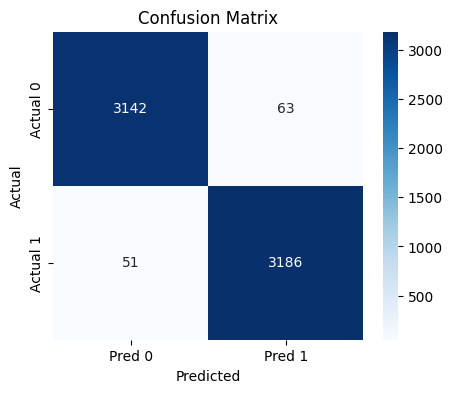

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [32]:
#Full clasification report

print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9840    0.9803    0.9822      3205
           1     0.9806    0.9842    0.9824      3237

    accuracy                         0.9823      6442
   macro avg     0.9823    0.9823    0.9823      6442
weighted avg     0.9823    0.9823    0.9823      6442



Test with data test CSV


In [33]:
print(sorted(df["label"].unique()))

[np.int64(0), np.int64(1)]


In [34]:
test_df = pd.read_csv(
    "/content/testing_data_lowercase_nolabels.csv",     # Using the uploaded filename
    sep="\t",
    header=None,
    names=["label", "title"],
    )


test_df["title"] = test_df["title"].astype(str)
test_df.head()

,label,title
0,2,copycat muslim terrorist arrested with assault...
1,2,wow! chicago protester caught on camera admits...
2,2,germany's fdp look to fill schaeuble's big shoes
3,2,mi school sends welcome back packet warning ki...
4,2,u.n. seeks 'massive' aid boost amid rohingya '...


In [35]:
from datasets import Dataset

test_ds = Dataset.from_pandas(test_df[["title"]].reset_index(drop=True))

def tokenize(batch):
    return tokenizer(
        batch["title"],
        truncation=True,
        padding="max_length",
        max_length=64
    )

test_ds = test_ds.map(tokenize, batched=True)
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask"])

Map:   0%|          | 0/9984 [00:00<?, ? examples/s]

In [39]:
pred = trainer.predict(test_ds)
y_pred = np.argmax(pred.predictions, axis=1)

test_df = test_df[["label", "title"]]
test_df["label"] = y_pred
test_df.head()

,label,title
0,0,copycat muslim terrorist arrested with assault...
1,0,wow! chicago protester caught on camera admits...
2,1,germany's fdp look to fill schaeuble's big shoes
3,0,mi school sends welcome back packet warning ki...
4,1,u.n. seeks 'massive' aid boost amid rohingya '...


In [40]:
test_df.to_csv(
    "validation_data_predictions.csv",
    sep="\t",
    header=False,
    index=False
)